In [1]:
# library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import tensorflow as tf
from scipy import stats
from tensorflow import keras
from sklearn.svm import SVR
from sklearn import preprocessing
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report
from pandas.plotting import scatter_matrix
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from xgboost.sklearn import XGBClassifier
from xgboost import XGBRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, LSTM
from tensorflow.keras.optimizers import Adam
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.model_selection import TimeSeriesSplit
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from sklearn.model_selection import cross_val_score, KFold
from sklearn.pipeline import Pipeline

2023-03-30 17:03:44.841491: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# load the data
df=pd.read_csv('/Users/yuting/Desktop/IAI5101_Group7-main/Covid_population_vaccine_fillna.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2325 entries, 0 to 2324
Data columns (total 20 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   pruid                        2325 non-null   int64  
 1   prname                       2325 non-null   object 
 2   date                         2325 non-null   object 
 3   reporting_year               2325 non-null   int64  
 4   numtotal_last7               2325 non-null   int64  
 5   ratecases_total              2325 non-null   float64
 6   numdeaths                    2325 non-null   int64  
 7   numdeaths_last7              2325 non-null   int64  
 8   ratedeaths                   2325 non-null   float64
 9   ratecases_last7              2325 non-null   float64
 10  ratedeaths_last7             2325 non-null   float64
 11  avgincidence_last7           2325 non-null   float64
 12  avgdeaths_last7              2325 non-null   float64
 13  avgratedeaths_last

## Add variable for datesets

In [4]:
# Preprocessing
df['date'] = pd.to_datetime(df['date'])

# Chosen the Province
df_province = df[df['prname'] == 'Ontario']  # Replace 'Ontario' with the desired province

# Feature selection
# Get all column names from the DataFrame
all_columns = df.columns.tolist()

# Remove the columns you want to exclude
exclude_columns = ['pruid', 'prname', 'date', 'totalcases']
features = [col for col in all_columns if col not in exclude_columns]

# 'features' now contains all columns except the ones in 'exclude_columns'
# features = ['numdeaths','numtotal_last7','numtotal_fully']
target = 'totalcases'

X = df_province[features]
y = df_province[target]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=2023)

# Standardize the features
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [5]:
# Train and evaluate different models
models = {
    'Linear Regression': LinearRegression(),
    'SVR': SVR(),
    'Decision Tree': DecisionTreeRegressor(),
    'KNN': KNeighborsRegressor(),
    'Random Forest': RandomForestRegressor(),
    'XGBoost': GradientBoostingRegressor(),
}

results = {}

for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    results[name] = {'MSE': mse, 'MAE': mae, 'R2': r2}
    
for name, result in results.items():
    print(f'{name}:')
    print(f'MSE: {result["MSE"]:.2f}, MAE: {result["MAE"]:.2f}, R2: {result["R2"]:.2f}\n')


Linear Regression:
MSE: 0.27, MAE: 0.44, R2: 1.00

SVR:
MSE: 275469115410.75, MAE: 440698.96, R2: -0.00

Decision Tree:
MSE: 220031004.19, MAE: 10489.17, R2: 1.00

KNN:
MSE: 1915734375.03, MAE: 28170.23, R2: 0.99

Random Forest:
MSE: 31058513.78, MAE: 4285.08, R2: 1.00

XGBoost:
MSE: 88928790.17, MAE: 6777.72, R2: 1.00



In [6]:
# LSTM model
X_train_lstm = X_train_scaled.reshape((X_train_scaled.shape[0], X_train_scaled.shape[1], 1))
X_test_lstm = X_test_scaled.reshape((X_test_scaled.shape[0], X_test_scaled.shape[1], 1))

lstm_model = Sequential()
lstm_model.add(LSTM(50, activation='relu', input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])))
lstm_model.add(Dense(1))
lstm_model.compile(optimizer=Adam(lr=0.001), loss='mse')

lstm_model.fit(X_train_lstm, y_train, epochs=50, batch_size=32, verbose=0)

y_pred_lstm = lstm_model.predict(X_test_lstm)
mse_lstm = mean_squared_error(y_test, y_pred_lstm)
mae_lstm = mean_absolute_error(y_test, y_pred_lstm)
r2_lstm = r2_score(y_test, y_pred_lstm)
results['LSTM'] = {'MSE': mse_lstm, 'MAE': mae_lstm, 'R2': r2_lstm}

print("LSTM:\n", f'MSE: {results["LSTM"]["MSE"]:.2f}, MAE: {results["LSTM"]["MAE"]:.2f}, R2: {results["LSTM"]["R2"]:.2f}\n')


2023-03-30 17:03:47.710147: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
/opt/anaconda3/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


2/2 [==============================] - 0s 3ms/step
LSTM:
 MSE: 25772770358.28, MAE: 136878.23, R2: 0.91



In [7]:
# ARIMA model
arima_model = ARIMA(y_train, order=(1, 1, 1)).fit()
y_pred_arima = arima_model.predict(start=len(y_train), end=len(y_train) + len(y_test) - 1, dynamic=False)
mse_arima = mean_squared_error(y_test, y_pred_arima)
mae_arima = mean_absolute_error(y_test, y_pred_arima)
r2_arima = r2_score(y_test, y_pred_arima)
results['ARIMA'] = {'MSE': mse_arima, 'MAE': mae_arima, 'R2': r2_arima}

print("ARIMA:\n", f'MSE: {results["ARIMA"]["MSE"]:.2f}, MAE: {results["ARIMA"]["MAE"]:.2f}, R2: {results["ARIMA"]["R2"]:.2f}\n')

ARIMA:
 MSE: 285751103913.00, MAE: 475504.89, R2: -0.04



/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


/var/folders/s1/4fm2_tw16qzdhqgqcb0ry6rm0000gn/T/ipykernel_78256/1045433669.py:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


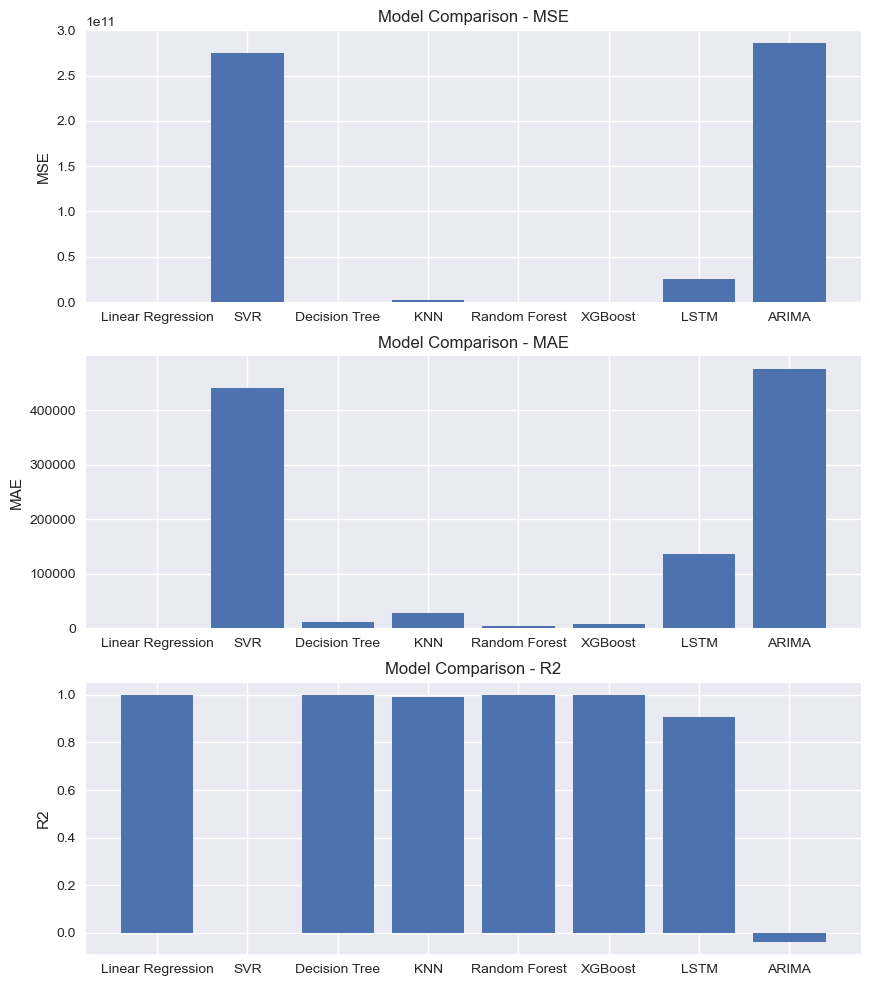

In [8]:
# Set style
plt.style.use('seaborn')
# Visualize the evaluation metrics

fig, axes = plt.subplots(3, 1, figsize=(10, 12))
for i, metric in enumerate(['MSE', 'MAE', 'R2']):
    axes[i].bar(results.keys(), [result[metric] for result in results.values()])
    axes[i].set_ylabel(metric)
    axes[i].set_title(f'Model Comparison - {metric}')
plt.show()

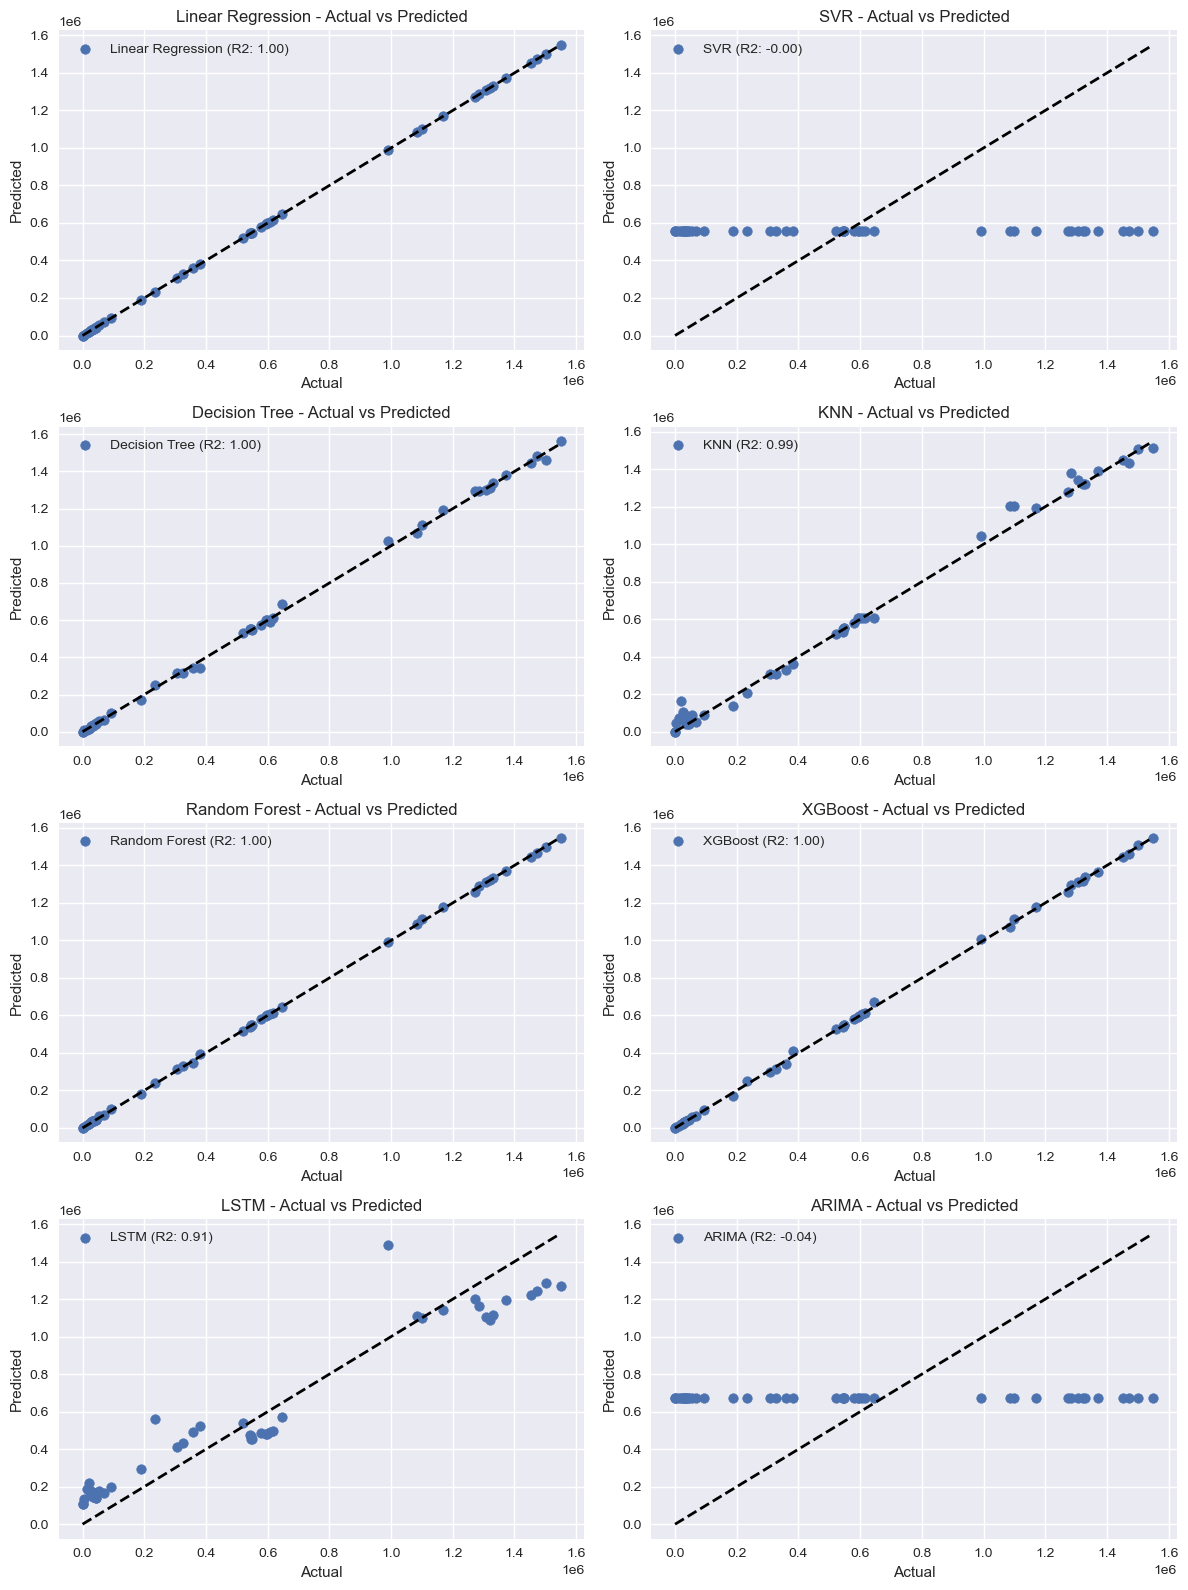

In [9]:
# Actual vs Predicted plots

fig, axes = plt.subplots(4, 2, figsize=(12, 16))
axes = axes.ravel()

for i, (name, model) in enumerate(models.items()):
    y_pred = model.predict(X_test_scaled)
    axes[i].scatter(y_test, y_pred, label=f'{name} (R2: {results[name]["R2"]:.2f})')
    axes[i].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
    axes[i].set_xlabel('Actual')
    axes[i].set_ylabel('Predicted')
    axes[i].legend()
    axes[i].set_title(f'{name} - Actual vs Predicted')

# LSTM Actual vs Predicted

axes[6].scatter(y_test, y_pred_lstm, label=f'LSTM (R2: {results["LSTM"]["R2"]:.2f})')
axes[6].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
axes[6].set_xlabel('Actual')
axes[6].set_ylabel('Predicted')
axes[6].legend()
axes[6].set_title('LSTM - Actual vs Predicted')

# ARIMA Actual vs Predicted

axes[7].scatter(y_test, y_pred_arima, label=f'ARIMA (R2: {results["ARIMA"]["R2"]:.2f})')
axes[7].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
axes[7].set_xlabel('Actual')
axes[7].set_ylabel('Predicted')
axes[7].legend()
axes[7].set_title('ARIMA - Actual vs Predicted')


plt.tight_layout()
plt.show()


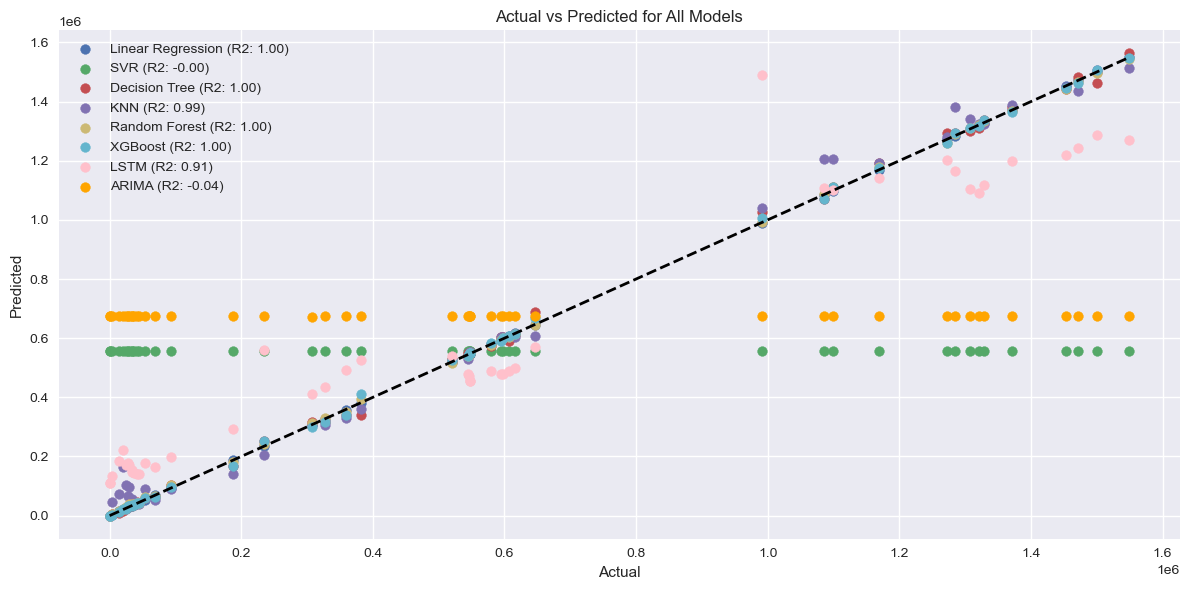

In [10]:
# plot all models
fig, ax = plt.subplots(figsize=(12, 6))

for i, (name, model) in enumerate(models.items()):
    y_pred = model.predict(X_test_scaled)
    ax.scatter(y_test, y_pred, label=f'{name} (R2: {results[name]["R2"]:.2f})')

# LSTM Actual vs Predicted
ax.scatter(y_test, y_pred_lstm, label=f'LSTM (R2: {results["LSTM"]["R2"]:.2f})', color='pink')

# ARIMA Actual vs Predicted
ax.scatter(y_test, y_pred_arima, label=f'ARIMA (R2: {results["ARIMA"]["R2"]:.2f})', color='orange')

ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
ax.set_xlabel('Actual')
ax.set_ylabel('Predicted')
ax.legend()
ax.set_title('Actual vs Predicted for All Models')

plt.tight_layout()
plt.show()


In [11]:
# Summarize the findings

best_model = max(results, key=lambda x: results[x]['R2'])
print("The best model is:", best_model)
print("Evaluation metrics for the best model are:")
print("MSE:", results[best_model]['MSE'])
print("MAE:", results[best_model]['MAE'])
print("R2:", results[best_model]['R2'])

The best model is: Linear Regression
Evaluation metrics for the best model are:
MSE: 0.26604150628945755
MAE: 0.44470259114594474
R2: 0.9999999999990336


### The final result will depend on the number of feature variables and can be changed at will to see the final result. For example, when features = ['numtotal_last7', 'numdeaths', 'numtotal_fully'], the best model is: XGBoost. Only when our variables increase, the final result will be linear regression.

# Time Series Split

In [12]:
# load the data
df=pd.read_csv('/Users/yuting/Desktop/IAI5101_Group7-main/Covid_population_vaccine_fillna.csv')

In [13]:
# Chosen the Province
# df_province = df[df['prname'] == 'Ontario']  # Replace 'Ontario' with the desired province

# Feature selection
# Get all column names from the DataFrame
all_columns = df.columns.tolist()

# Remove the columns you want to exclude
exclude_columns = ['pruid', 'prname', 'date', 'reporting_year','totalcases']
features = [col for col in all_columns if col not in exclude_columns]
# features = ['numdeaths','ratedeaths','Population','numtotal_fully','numtotal_partially']
target = 'totalcases'


X = df_province[features]
y = df_province[target]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2023)


In [14]:
# Train-test split using TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=4)
for train_index, test_index in tscv.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

In [15]:
# Standardize the features
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [16]:
# Train and evaluate different models
models = {
    'Linear Regression': LinearRegression(),
    'SVR': SVR(),
    'Decision Tree': DecisionTreeRegressor(),
    'KNN': KNeighborsRegressor(),
    'Random Forest': RandomForestRegressor(),
    'XGBoost': GradientBoostingRegressor(),
}

results = {}

for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    results[name] = {'MSE': mse, 'MAE': mae, 'R2': r2}
    
for name, result in results.items():
    print(f'{name}:')
    print(f'MSE: {result["MSE"]:.2f}, MAE: {result["MAE"]:.2f}, R2: {result["R2"]:.2f}\n')
    
# ARIMA model
arima_model = ARIMA(y_train, order=(1, 1, 1)).fit()
y_pred_arima = arima_model.predict(start=len(y_train), end=len(y_train) + len(y_test) - 1, dynamic=False)
mse_arima = mean_squared_error(y_test, y_pred_arima)
mae_arima = mean_absolute_error(y_test, y_pred_arima)
r2_arima = r2_score(y_test, y_pred_arima)
results['ARIMA'] = {'MSE': mse_arima, 'MAE': mae_arima, 'R2': r2_arima}

print("ARIMA:\n", f'MSE: {results["ARIMA"]["MSE"]:.2f}, MAE: {results["ARIMA"]["MAE"]:.2f}, R2: {results["ARIMA"]["R2"]:.2f}\n')

# LSTM model
X_train_lstm = X_train_scaled.reshape((X_train_scaled.shape[0], X_train_scaled.shape[1], 1))
X_test_lstm = X_test_scaled.reshape((X_test_scaled.shape[0], X_test_scaled.shape[1], 1))

lstm_model = Sequential()
lstm_model.add(LSTM(50, activation='relu', input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])))
lstm_model.add(Dense(1))
lstm_model.compile(optimizer=Adam(lr=0.001), loss='mse')

lstm_model.fit(X_train_lstm, y_train, epochs=50, batch_size=32, verbose=0)

y_pred_lstm = lstm_model.predict(X_test_lstm)
mse_lstm = mean_squared_error(y_test, y_pred_lstm)
mae_lstm = mean_absolute_error(y_test, y_pred_lstm)
r2_lstm = r2_score(y_test, y_pred_lstm)
results['LSTM'] = {'MSE': mse_lstm, 'MAE': mae_lstm, 'R2': r2_lstm}

print("LSTM:\n", f'MSE: {results["LSTM"]["MSE"]:.2f}, MAE: {results["LSTM"]["MAE"]:.2f}, R2: {results["LSTM"]["R2"]:.2f}\n')



Linear Regression:
MSE: 0.17, MAE: 0.36, R2: 1.00

SVR:
MSE: 1168112342970.79, MAE: 1078107.23, R2: -200.51

Decision Tree:
MSE: 27008227002.90, MAE: 142479.03, R2: -3.66

KNN:
MSE: 29496305468.97, MAE: 157194.48, R2: -4.09

Random Forest:
MSE: 32680395005.50, MAE: 159342.00, R2: -4.64

XGBoost:
MSE: 37563707575.43, MAE: 170355.57, R2: -5.48

ARIMA:
 MSE: 11817834048.65, MAE: 90410.95, R2: -1.04



/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/anaconda3/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_ra

1/1 [==============================] - 0s 114ms/step
LSTM:
 MSE: 153535035412.88, MAE: 390975.03, R2: -25.49



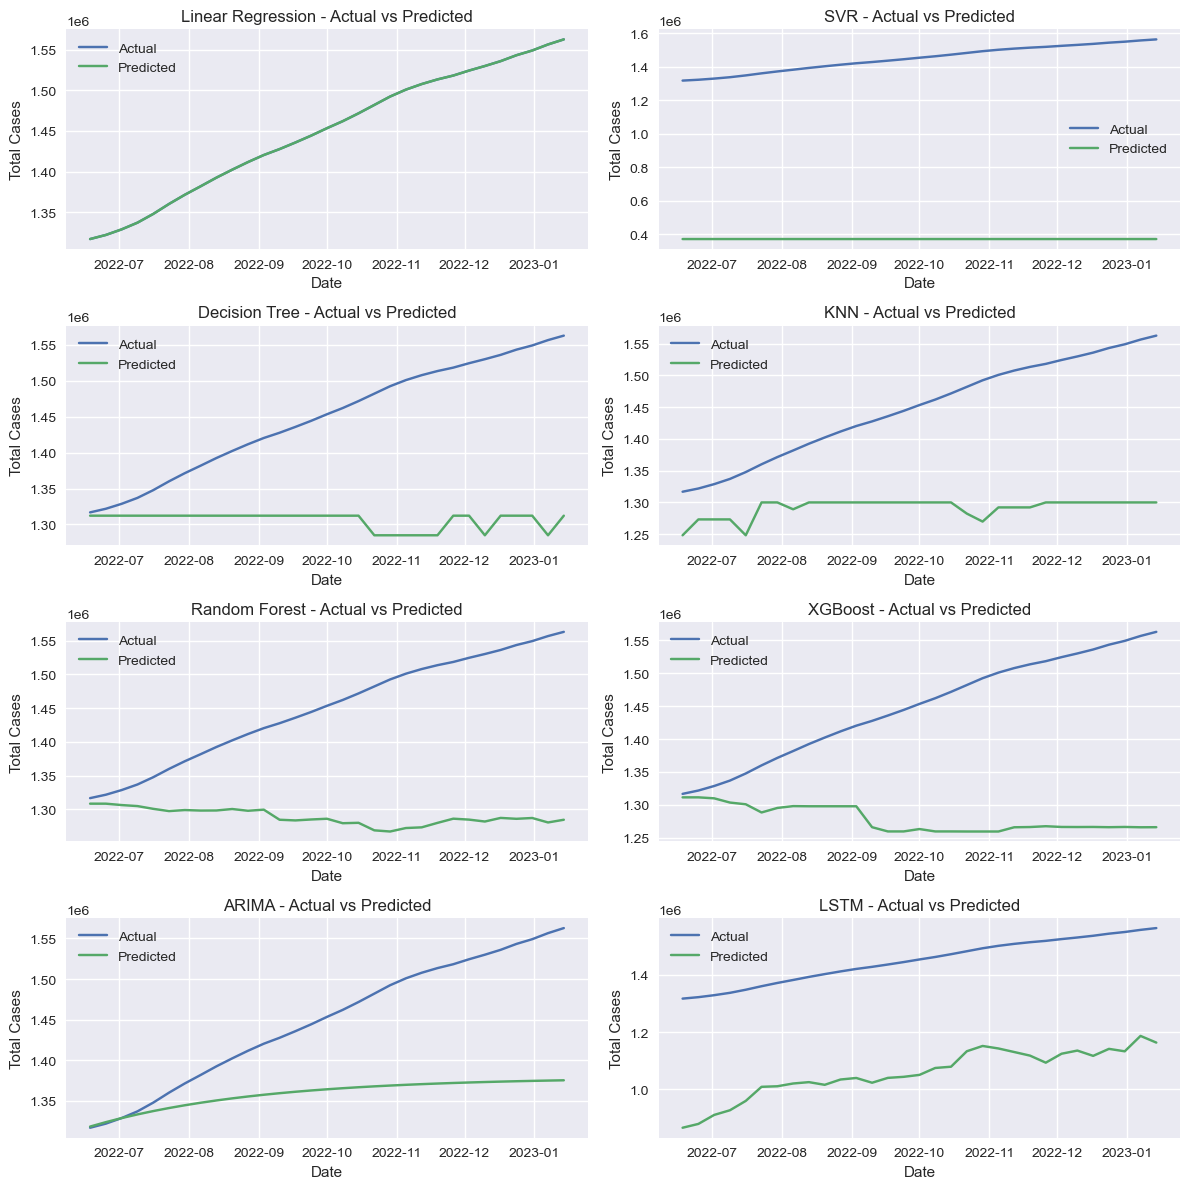

In [17]:
# Plot the predictions of each model with date
fig, axes = plt.subplots(4, 2, figsize=(12, 12))
axes = axes.ravel()

test_dates = df_province['date'].iloc[test_index]

for i, (name, model) in enumerate(models.items()):
    y_pred = model.predict(X_test_scaled)
    axes[i].plot(test_dates, y_test, label='Actual')
    axes[i].plot(test_dates, y_pred, label='Predicted')
    axes[i].set_xlabel('Date')
    axes[i].set_ylabel('Total Cases')
    axes[i].legend()
    axes[i].set_title(f'{name} - Actual vs Predicted')

# ARIMA Actual vs Predicted
axes[6].plot(test_dates, y_test, label='Actual')
axes[6].plot(test_dates, y_pred_arima, label='Predicted')
axes[6].set_xlabel('Date')
axes[6].set_ylabel('Total Cases')
axes[6].legend()
axes[6].set_title('ARIMA - Actual vs Predicted')

# LSTM Actual vs Predicted
axes[7].plot(test_dates, y_test, label='Actual')
axes[7].plot(test_dates, y_pred_lstm.flatten(), label='Predicted')
axes[7].set_xlabel('Date')
axes[7].set_ylabel('Total Cases')
axes[7].legend()
axes[7].set_title('LSTM - Actual vs Predicted')

plt.tight_layout()
plt.show()

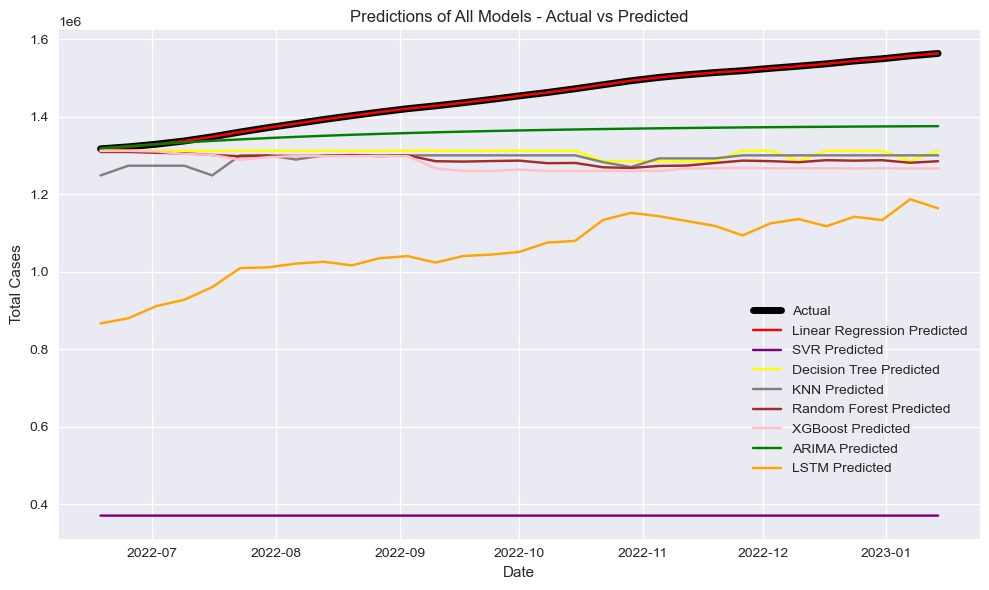

In [18]:
# Plot the predictions of all models in one plot
fig, ax = plt.subplots(figsize=(10, 6))

test_dates = df_province['date'].iloc[test_index]

# Specify colors for the lines
colors = {
    'Actual': 'k',
    'Linear Regression': 'red',
    'SVR': 'purple',
    'Decision Tree': 'yellow',
    'KNN': 'grey',
    'Random Forest': 'brown',
    'XGBoost': 'pink',
    'ARIMA': 'green',
    'LSTM': 'orange'
}

# Plot actual values
ax.plot(test_dates, y_test, label='Actual', color=colors['Actual'], linewidth=5)

# Plot predictions of models
for name, model in models.items():
    y_pred = model.predict(X_test_scaled)
    ax.plot(test_dates, y_pred, label=f'{name} Predicted', color=colors[name])

# Plot ARIMA predictions
ax.plot(test_dates, y_pred_arima, label='ARIMA Predicted', color=colors['ARIMA'])

# Plot LSTM predictions
ax.plot(test_dates, y_pred_lstm.flatten(), label='LSTM Predicted', color=colors['LSTM'])

ax.set_xlabel('Date')
ax.set_ylabel('Total Cases')
ax.legend(loc='lower right', bbox_to_anchor=(1.0, 0.1))
ax.set_title('Predictions of All Models - Actual vs Predicted')

plt.tight_layout()
plt.show()

In [19]:
# Summarize the findings
best_model = max(results, key=lambda x: results[x]['R2'])
print("The best model is:", best_model)
print("Evaluation metrics for the best model are:")
print("MSE:", results[best_model]['MSE'])
print("MAE:", results[best_model]['MAE'])
print("R2:", results[best_model]['R2'])

The best model is: Linear Regression
Evaluation metrics for the best model are:
MSE: 0.1716789971589783
MAE: 0.35876381467847573
R2: 0.9999999999703845


In [20]:
### Cross-Validation
# Create a list of models to compare
models = [
    ('Linear Regression', LinearRegression()),
    ('SVR', SVR(kernel='linear')),
    ('Random Forest', RandomForestRegressor()),
    ('KNN', KNeighborsRegressor()),
    ('Decision Tree', DecisionTreeRegressor()),
    ('XGBoost', XGBRegressor())
]

# Set up cross-validation with 5 folds
kfold = KFold(n_splits=10, shuffle=True, random_state=2023)

# Compare models using cross_val_score
results = []
for name, model in models:
    # Standardize the data for models sensitive to feature scaling
    pipeline = Pipeline([('scaler', StandardScaler()), ('model', model)])
    
    # Perform cross-validation and calculate scores
    scores = cross_val_score(pipeline, X, y, cv=kfold, scoring='neg_mean_squared_error')
    results.append((name, scores))

# Print results
for name, scores in results:
    print(f'{name}: MSE: {scores.mean():.2f}, Standard Deviation: {scores.std():.2f}')


Linear Regression: MSE: -0.21, Standard Deviation: 0.04
SVR: MSE: -308012743562.55, Standard Deviation: 88102923379.10
Random Forest: MSE: -96973426.26, Standard Deviation: 116385848.41
KNN: MSE: -4687096549.94, Standard Deviation: 3591367769.70
Decision Tree: MSE: -406827805.83, Standard Deviation: 341744985.37
XGBoost: MSE: -431986649.45, Standard Deviation: 374617691.56
